# Topic modeling on abstracts

## 1. Preprocessing

In [29]:
import pandas as pd
import os 
import numpy as np
import re

In [30]:
import nltk
from nltk import word_tokenize, RegexpTokenizer,PunktSentenceTokenizer, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [ ]:
#!pip install gensim

In [31]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

### 1.1 Load the data 

In [32]:
abstracts = pd.read_csv("abstracts.csv")

In [33]:
abstracts.head()

,abstract,id
0,The goal of this note is to introduce new clas...,188444.0
1,We will review a Lemma published by Ran Raz in...,188623.0
2,China’s growing influence in Europe has the po...,346708.0
3,Nowhere is China's Belt and Road Initiative (B...,346709.0
4,The chapter examines to what extent Alison and...,359017.0


In [34]:
abs_list = list(abstracts['abstract'])

In [35]:
len(abs_list)

21421

**21421** abstracts in total

### 1.2 Step 1 
- tokenization 
- punctuation removal 
- lowercasing

In [36]:
tokenised = []
count = 0
for abstract in abs_list:
    raw = abstract
    tokens = gensim.utils.simple_preprocess(str(raw), deacc=True)
    tokenised.append(tokens)
    count += len(tokens)
print(str(count)+" tokens created")

4003032 tokens created


In [41]:
c = []
for doc in tokenised: 
    c+=doc
len(set(c))

83831

So we have **83831** unique words in the beginning

### 1.3 Step 2 
- removing stopwords 
- (removing other words based on different strategies - like word length thresholding) 

In [42]:
stop_words = stopwords.words('english')
cleaned = [[word for word in doc if word not in stop_words] for doc in tokenised]

In [ ]:
# Consider extending the stopwords ...
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
# Consider removing words with less than [x] characters 

In [44]:
c = []
for doc in cleaned: 
    c+=doc
len(set(c))

83695

Now after stopwords removal we have **83695** terms (136 less)

### 1.4 Step 3 
- stemming 
- lemmatizing 

In [23]:
#nltk.download('wordnet')

In [45]:
word_stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()
cleaned = [[lemmatiser.lemmatize(word_stemmer.stem(word)) for word in doc] for doc in cleaned]

In [47]:
c = []
for doc in cleaned: 
    c+=doc
len(set(c))

61182

And after stemming and lemmatization we have **61182** terms (22,513 less)

### 1.5 Build n-grams

In [ ]:
bigram = gensim.models.Phrases(tokenised, min_count=5, threshold=100) # higher threshold fewer phrases.

In [ ]:
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

### 1.6 Analyse the vocabulary

In [48]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [49]:
wordlist = flatten(cleaned)

In [51]:
from collections import Counter
counts = Counter(wordlist)

In [53]:
counts.most_common(10)

[('use', 20320),
 ('model', 18903),
 ('result', 12794),
 ('studi', 12169),
 ('data', 11853),
 ('differ', 10236),
 ('base', 9886),
 ('system', 9371),
 ('measur', 8956),
 ('show', 8800)]

In [56]:
hist(counts.most_common(10))

## 2. Modelling

### LDA

In [59]:
#!pip3.7 install tomotopy

In [60]:
import sys
import tomotopy as tp

In [77]:
# Defining hyperparameters
tw = tp.TermWeight.ONE # term weighting scheme in TermWeight. The default value is TermWeight.ONE
k = 20 # number of topics...
min_cf=3 # minimum collection frequency of words. Words with a smaller collection frequency than min_cf are excluded from the model. The default value is 0, which means no words are excluded.
min_df=0 # minimum document frequency of words. Words with a smaller document frequency than min_df are excluded from the model. The default value is 0, which means no words are excluded
rm_top=5 # the number of top words to be removed. If you want to remove too common words from model, you can set this value to 1 or more. The default value is 0, which means no top words are removed.
alpha = None # hyperparameter of Dirichlet distribution for document-topic
eta = None # hyperparameter of Dirichlet distribution for topic-word
seed = 41 # random seed
model_burn_in = 100 
train_updates = 1000
train_iter = 10
save_path = "lda_model"

In [69]:
# Instantiating the model
model = tp.LDAModel(tw=tp.TermWeight.ONE, min_cf=min_cf, rm_top=rm_top, k=k)

In [70]:
# adding documents to the model 
for doc in cleaned: model.add_doc(doc)

In [71]:
# training**
model.burn_in = model_burn_in
# initialising 
model.train(iter=0)
print('Num docs:', len(model.docs), ', Vocab size:', len(model.used_vocabs), ', Num words:', model.num_words)
print('Removed top words:', model.removed_top_words)
print('Training...', file=sys.stderr, flush=True)
# actual training 
time = []
LLs = []
for i in range(0, train_updates, train_iter):
    model.train(train_iter)
    if i%100==0:print('Iteration: {}'.format(i))
    time.append(i)
    LLs.append(model.ll_per_word)

Training...


Num docs: 21421 , Vocab size: 28212 , Num words: 2494300
Removed top words: ['use', 'model', 'result', 'studi', 'data']
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900


Text(0.5, 0, 'Iteration')

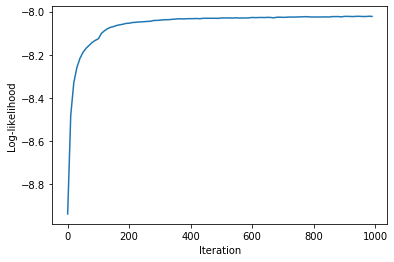

In [74]:
import matplotlib.pyplot as plt
plt.plot(time,LLs)
plt.ylabel('Log-likelihood')
plt.xlabel('Iteration')

In [75]:
model.summary()

<Basic Info>
| LDAModel (current version: 0.9.1)
| 21421 docs, 2494300 words
| Total Vocabs: 61182, Used Vocabs: 28212
| Entropy of words: -8.15075
| Removed Vocabs: use model result studi data
|
<Training Info>
| Iterations: 1000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -8.02214
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| alpha: 0.1 (hyperparameter of Dirichlet distribution for document-topic)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 1443100946 (random seed)
| trained in version 0.9.1
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.048902   0.03391528 0.12352751 0.06520332 0.05332191 0.06061967
|   0.04910828 0.02443163 0.01074238 0.03457771 0.04973521 0.03293201
|   0.025371

In [78]:
print('Saving...', file=sys.stderr, flush=True)
model.save(save_path, full=True) # If full is True, the model with its all documents and state will be saved. If you want to train more after, use full model. If False, only topic parameters of the model will be saved. This model can be only used for inference of an unseen document.

Saving...


Let's have a better look at the results!

In [80]:
for k in range(model.k):
    print('Topic #{}'.format(k))
    for word, prob in model.get_topic_words(k):
        print('\t', word, prob, sep='\t')

Topic #0
		cell	0.036528538912534714
		protein	0.016236234456300735
		express	0.011620637960731983
		activ	0.009825684130191803
		gene	0.009126351214945316
		regul	0.008444502018392086
		function	0.007646096870303154
		signal	0.006393125746399164
		transcript	0.005687965080142021
		respons	0.005652998574078083
Topic #1
		gene	0.018455689772963524
		genom	0.014132915064692497
		sequenc	0.0132948262616992
		popul	0.011398098431527615
		genet	0.010471790097653866
		speci	0.010092443786561489
		host	0.007983989082276821
		resist	0.006704800296574831
		select	0.006651868112385273
		differ	0.006484250538051128
Topic #2
		research	0.01288377121090889
		develop	0.011311017908155918
		design	0.007463211193680763
		new	0.007379133254289627
		process	0.00724065164104104
		provid	0.00709227891638875
		system	0.0064048171043396
		approach	0.006078396458178759
		inform	0.005930023733526468
		discus	0.005865728482604027
Topic #3
		countri	0.00958346202969551
		polici	0.009576769545674324
		effect	0.0

In [81]:
# TODO: implement grid-search for best k (choose based on LL)
# + other hyperparameters tuning

In [ ]:
# TODO: use new quality measures

## Next up

- experimenting with bigrams/trigrams
- more solid results on LDA (with other measures and grid-search) 
- experimenting with CTM
- experimenting with Pachinko